In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 14), (2500, 14), (7500,), (2500,))

In [6]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [8]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col)),
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler()),
            ])
    final_transformers.append((cont_col, cont_transformer))

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Precison - это насколько точно модель определяет положительный класс, среди того, что модель назвала положительным классом.

Recall - полнота, показывает сколько модель нашла положительных ответов среди действительно положительных ответов.

Recall показывает способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов. 

Если подобрать порог для recall = 1, то модель все объекты будет относить к положительным, при этом FP сильно вырастет и упадет TN. 

Если сделать precision = 1, то алгоритм будет пропускать положительный класс. Вырастет доля FN и уменьшится доля TP.

**1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)**

**RandomForestClassifier**

In [11]:
pipeline_RFC = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

pipeline_RFC.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [12]:
preds = pipeline_RFC.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.17, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [13]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

fscore_RFC = fscore[ix]
precision_RFC = precision[ix]
recall_RFC = recall[ix]

roc_auc_score_RFC = roc_auc_score(y_test, preds)

**Logistic regression**

In [14]:
pipeline_LR = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(C=0.1,  random_state=24)),
])

pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [15]:
preds = pipeline_LR.predict_proba(X_test)[:, 1]
preds[:-10]

array([0.22855166, 0.33314466, 0.15635778, ..., 0.08152999, 0.21183408,
       0.03672681])

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

fscore_LR = fscore[ix]
precision_LR = precision[ix]
recall_LR= recall[ix]

roc_auc_score_LR = roc_auc_score(y_test, preds)

**XGBoost**

In [17]:
pipeline_XGB = Pipeline([
    ('features',feats),
    ('classifier', xgb.XGBClassifier(max_depth=5, n_estimators=100, random_state=42, reg_alpha=0.1, reg_lambda=1e-3)),
])

pipeline_XGB.fit(X_train, y_train)

C:\Users\gribanov\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:19:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [18]:
preds_XGB = pipeline_XGB.predict_proba(X_test)[:, 1]
preds_XGB[:10]

array([0.4735598 , 0.30615717, 0.18960151, 0.07835434, 0.05621345,
       0.84078604, 0.05933473, 0.08448657, 0.04415148, 0.74001336],
      dtype=float32)

In [19]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_XGB)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)

fscore_XGB = fscore[ix]
precision_XGB = precision[ix]
recall_XGB = recall[ix]

roc_auc_score_XGB = roc_auc_score(y_test, preds_XGB)

**2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)**

In [20]:
metrics_table = pd.DataFrame(data={'Metrics':['Precision', 'Recall', 'F-score', 'Roc_auc_score'],
                               'RFClassifier':[precision_RFC, recall_RFC, fscore_RFC, roc_auc_score_RFC],
                               'XGBoost':[precision_XGB, recall_XGB, fscore_XGB, roc_auc_score_XGB],
                              'LogReg':[precision_LR, recall_LR, fscore_LR, roc_auc_score_LR]}, dtype=np.float) 
metrics_table = metrics_table.set_index('Metrics')
metrics_table

,RFClassifier,XGBoost,LogReg
Metrics,,,
Precision,0.654397,0.614943,0.466558
Recall,0.628684,0.630648,0.561886
F-score,0.641283,0.622696,0.509804
Roc_auc_score,0.863699,0.861142,0.772628


Если не брать во внимание RFC (из урока), то показала себя лучше модель XGB.

**3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.**

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1790  201]
 [ 189  320]]


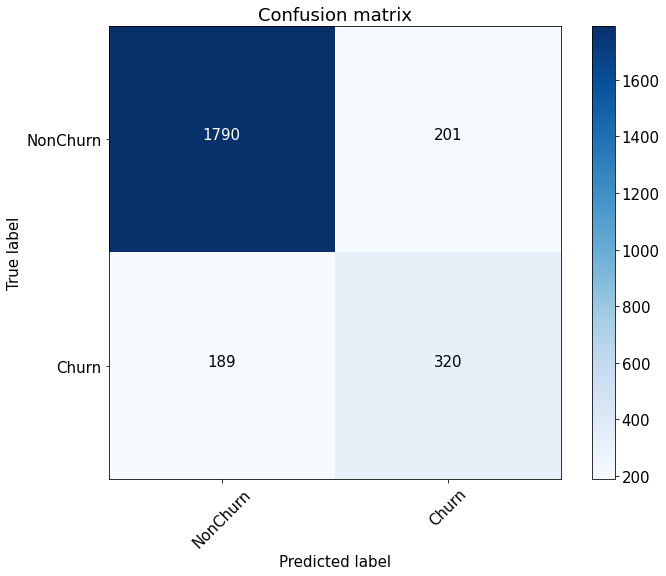

In [22]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds_XGB > thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

* TP = 320 - модель сказала, что уйдет и ушел бы - 1 доллар чтобы удержать его (+ 2 доллара за каждого кто реально хотел уйти)
* FP = 201 - модель сказала, что уйдет, но ошиблась - 1 доллар чтобы удержать его
* TN = 1790 - модель сказала, что не уйдет и не ушел
* FN = 189 - модель сказала, что не уйдет, но ошиблась



In [23]:
TP = 320
FP = 201

In [24]:
print(f'Потенциальная выгода от модели = {2 * TP - TP - FP} доллара')

Потенциальная выгода от модели = 119 доллара
